## Simulating any compartmental model with testing and quarantine using the `SppQ` class



In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
#from matplotlib import rc; rc('text', usetex=True)

### The SIR model with quarantine

Below you will find the model-specification dictionary for the SIR model with quarantined states

In [3]:
model_spec = {
    "classes" : ["S", "I"],

    "S" : {
        "infection" : [ ["I", "-beta"] ],
    },

    "I" : {
        "linear"    : [ ["I", "-gamma"] ],
        "infection" : [ ["I", "beta"] ],
    },
    
    #                S              I           R
    "test_pos"  : [ "p_falsepos", "p_truepos", "p_falsepos"] ,
    "test_freq" : [ "pi_RS",      "pi_I",      "pi_RS"] 
}

parameters = {
    'beta' : 0.02,
    'gamma' : 0.1, 
    'p_falsepos' : 0.01,
    'p_truepos'  : 0.9,
    'pi_RS'      : 0.1,
    'pi_I'      : 1
    
}

This corresponds to

$$
\begin{aligned}
\dot{S}_i & =  - \beta \sum_j C_{ij} \frac{I_j}{N_j} S_i - \tau_S S_i; &\dot{S}^Q_i & =  \tau_S S_i \\
\dot{I}_i & = \beta \sum_j C_{ij} \frac{I_j}{N_j} S_i - \gamma I_i - \tau_I I_i;
&\dot{I}^Q_i & =- \gamma I_i^Q+ \tau_I I_i\\
\dot{R}_i & = \gamma I_i- \tau_R R_i; &\dot{R}^Q_i & = \gamma I^Q_i+ \tau_R R_i;
\end{aligned}
$$

Each of the classes, `S`, `I` and `R`,  have a quarantined version, `SQ`, `IQ` and `RQ`. The dynamics within the quarantined states is the same as for the un-quarantined states, but there are no infection terms (assuming perfect quarantine). Individuals are quarantined upon testing positive, hence the total number $N^Q=S^Q+I^Q+R^Q$ would be the reported number of confirmed cases. 

The transition rates $\tau_S$, $\tau_I$, $\tau_R$ for irreversible transitions to the quarantined states are dependent on time and on other variables. They are determined by the overall testing rate $\tau_{tot}(t)$ and the parameters specified in `"test_pos"` and `"test_prob"` (ordered such that they match to `S`, `I` and `R`).  

- `"test_pos"` specifies the probability $\kappa_S$, $\kappa_I$, $\kappa_R$ that a test performed on an individual of a given class is positive. For classes $R$ and $S$, this is the conditional probability of false positives, for class $I$ the conditional probability of a true positive

- `"test_freq"` characterises the frequency $\pi_S$, $\pi_I$, $\pi_R$ of tests in a given class. The absolute values of these values does not matter, only their relative magnitudes. If we consider symptomatic testing and set $\pi_I=1$, then $\pi_R=\pi_S$ is the fraction of people who would like to be tested because of symptoms of flu or cold among the population *not* infected with SARS-CoV-2. In models with several infected classes, this parameter can also be used to prioritise testing of patients with severe symptoms or elderly people

- The rate of positive tests in each class is computed as
  $$ \tau_X=\tau_{tot}(t)\pi_X \kappa_X/\mathcal{N} $$
  for $X\in\{S,I,R\}$ with the normalisation constant
  $$ \mathcal{N}=\sum_X \pi_X  X$$

Next, we define the initial condition for all non-quarantined and quarantined states. $R$ is never specified but calculated from the total number. The initial value for $N^Q$ is specified for the auxiliary class `NiQ`. The (scalar) testing rate $\tau_{tot}(t)$ is specified as a Python function, similar to the time dependent contact matrix. Here, we specify a rapid increase from 10 to 100 tests per day around day 40.

In [4]:
M = 2                # the population has two age groups
N = 5e4              # and this is the total population

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
CM = np.array([[18., 9.], [3., 12.]])


# Initial conditions as an array
S0 = np.array([Ni[0]-10, Ni[1]-10])
I0 = np.array([10,   10])

x0 = np.array([
    S0[0], S0[1],   # S
    I0[0], I0[1],   # I
    0,   0,     # SQ
    0,   0,     # IQ
    0,   0      # NiQ
])


def contactMatrix(t):  
    return CM

# Tests performed per day
def testRate(t):
    return (900.*(1.+np.tanh((t-30.)/10.))/2.+100.)

# duration of simulation and data file
Tf = 100;  Nf=Tf+1; 

model = pyross.stochastic.SppQ(model_spec, parameters, M, Ni)
data = model.simulate(x0, contactMatrix, testRate, Tf, Nf)
data_array = data['X']

det_model = pyross.deterministic.SppQ(model_spec, parameters, M, Ni)
data_det = det_model.simulate(x0, contactMatrix, testRate, Tf, Nf)
data_array_data = data_det['X']

# non-quarantined version for comarpison
model_specU = model_spec.copy()
model_specU.pop('test_freq')
model_specU.pop('test_pos')
modelU = pyross.stochastic.Spp(model_specU, parameters, M, Ni)
dataU = modelU.simulate(x0[0:(2*M)], contactMatrix, Tf, Nf)

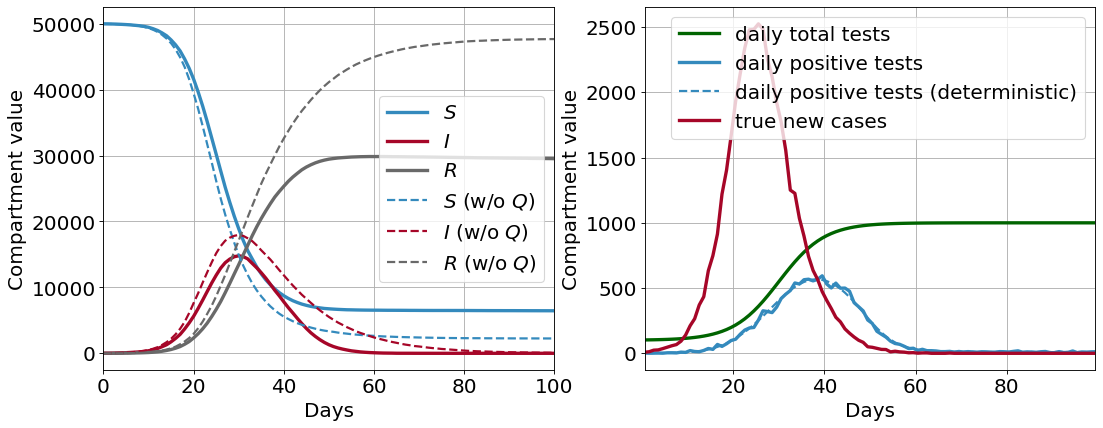

In [5]:
# plot the data and obtain the epidemic curve
S = np.sum(model.model_class_data('S', data), axis=1)
I = np.sum(model.model_class_data('I', data), axis=1)
R = np.sum(model.model_class_data('R', data), axis=1)
SQ = np.sum(model.model_class_data('SQ', data), axis=1)
IQ = np.sum(model.model_class_data('IQ', data), axis=1)
RQ = np.sum(model.model_class_data('RQ', data), axis=1)
NQ = np.sum(model.model_class_data('NiQ', data), axis=1)

NQ_det = np.sum(det_model.model_class_data('NiQ', data_det), axis=1)

SU = np.sum(modelU.model_class_data('S', dataU), axis=1)
IU = np.sum(modelU.model_class_data('I', dataU), axis=1)
RU = np.sum(modelU.model_class_data('R', dataU), axis=1)

t = data['t']

fig = plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 18})

plt.subplot(1, 2, 1)
plt.plot(t, S, '-', color="#348ABD", label='$S$', lw=3)
plt.plot(t, I, '-', color='#A60628', label='$I$', lw=3)
plt.plot(t, R, '-', color="dimgrey", label='$R$', lw=3)
plt.plot(t, SU, '--', color="#348ABD", label='$S$ (w/o $Q$)', lw=2)
plt.plot(t, IU, '--', color='#A60628', label='$I$ (w/o $Q$)', lw=2)
plt.plot(t, RU, '--', color="dimgrey", label='$R$ (w/o $Q$)', lw=2)

plt.legend(fontsize=18); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

plt.subplot(1, 2, 2)
tm = t[1:]-0.5
plt.plot(tm, [testRate(tt) for tt in tm], '-', color="darkgreen", label='daily total tests', lw=3)
plt.plot(tm, np.diff(NQ), '-', color="#348ABD", label='daily positive tests', lw=3)
plt.plot(tm, np.diff(NQ_det), '--', color="#348ABD", label='daily positive tests (deterministic)', lw=2)
plt.plot(tm, np.diff(I+R+IQ+RQ), '-', color="#A60628", label='true new cases', lw=3)

plt.legend(fontsize=18); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

In this simple model, testing and quarantining has helped to eradicate the disease. It is interesting to evaluate how many infections have been confired anf how many have remained unconfirmed:

In [6]:
print("Confirmed cases:", int(RQ[-1]))
print("Confirmed cases (incl. false positives):", int(NQ[-1]))
print("Total cases:", int(R[-1]+RQ[-1]))

Confirmed cases: 13833
Confirmed cases (incl. false positives): 14018
Total cases: 43361


In [7]:
# load the data and rescale to intensive variables 
Tf_inference = 30 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1
x = (data_array[:Nf_inference]).astype('float')/N 

inference_parameters = parameters.copy()

In [8]:
# a filter that sums over all the diagnosed people for each age group
fltr = np.kron([0, 0, 0, 0, 1],np.identity(M))
print(fltr)

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
obs=np.einsum('ij,kj->ki', fltr, x)
x0=x[0]

# initialise the estimator 
steps = 4 # number internal integration steps taken
estimator = pyross.inference.SppQ(model_spec, inference_parameters, testRate, M, fi, N, steps, lyapunov_method='euler')


# compute -log_p for the original (correct) parameters 
logp = estimator.minus_logp_red(inference_parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
print(logp) 

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
-447.9353894870711


In [9]:
# make parameter guesses and set up bounds for each parameter 
eps=1e-4

beta_g = 0.015
beta_std = 0.015
beta_b = (eps, 0.1)

gamma_g = 0.15
gamma_std = 0.1 
gamma_b = (eps, 1)


I0_g = (I0+3)/N
I_std = I0_g*0.4 
bounds_for_I = np.tile([0.1/N, 100/N], M).reshape(M, 2)

S0_g = (S0-3)/N
S_std = I_std*np.sqrt(3)
bounds_for_S = np.array([(1/N, f-1/N) for f in fi]).reshape(M, 2)

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# set up bounds, guess and stds for the rest of the params 
keys = ['beta', 'gamma']
bounds = np.array([beta_b, gamma_b, 
                   *bounds_for_S, *bounds_for_I])
guess = np.array([beta_g, gamma_g, *S0_g, *I0_g])
stds = np.array([beta_std, gamma_std, *S_std, *I_std])

# set up fltr for initial conditions because they are constraint by the observed 
init_fltr = np.repeat([True, True, False], M)

# set up filter for initial conditions because they are constraint by the observed 
# note that this filter is different from the bulk of the trajectory, 
# because we know the initial value 0 holds for all quarantined age groups
init_fltr = np.repeat([True, True, False, False, False], M)
fltr0=np.kron(([[0, 0, 1, 0, 0],[0, 0, 0, 1, 0],[0, 0, 0, 0, 1]]), np.identity(M))
obs0=np.zeros(M*3)


params = estimator.latent_infer_parameters(keys, init_fltr, guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                    global_max_iter=10, global_atol=10, 
                                    verbose=True, ftol=ftol, obs0=obs0, fltr0=fltr0) 

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 6 (seed=3317457303, Mon Jun  8 23:56:06 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -3.176785645021674e+02 1.0e+00 1.07e+00  1e-04  1e-01 0:00.7
    2     32 -4.592697482632358e+02 1.5e+00 1.00e+00  9e-05  9e-02 0:01.4
    3     48 -4.634401523142724e+02 1.5e+00 9.71e-01  8e-05  9e-02 0:02.2
    5     80 -4.612470637201353e+02 1.7e+00 9.51e-01  8e-05  9e-02 0:03.6
Optimal value (global minimisation):  -463.4401523142724
Starting local minimisation...
Optimal value (local minimisation):  -492.0408707887491


In [10]:
print("True parameters:")
print(inference_parameters)

print("\nInferred parameters:")
best_estimates = estimator.fill_params_dict(keys, params)
print(best_estimates)

print('\n True initial conditions: ') 
print(x0*N)

partial_inits = params[len(keys):]
x0_estimate = estimator.fill_initial_conditions(partial_inits, obs0, init_fltr, fltr0)
print('\n Inferred initial conditons: ') 
print((x0_estimate*N).astype('int'))

True parameters:
{'beta': 0.02, 'gamma': 0.1, 'p_falsepos': 0.01, 'p_truepos': 0.9, 'pi_RS': 0.1, 'pi_I': 1}

Inferred parameters:
{'beta': 0.020945657400999386, 'gamma': 0.11640420071698557, 'p_falsepos': array([0.01, 0.01]), 'p_truepos': array([0.9, 0.9]), 'pi_RS': array([0.1, 0.1]), 'pi_I': array([1., 1.])}

 True initial conditions: 
[1.249e+04 3.749e+04 1.000e+01 1.000e+01 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00]

 Inferred initial conditons: 
[12483 37483    12    13     0     0     0     0     0     0]


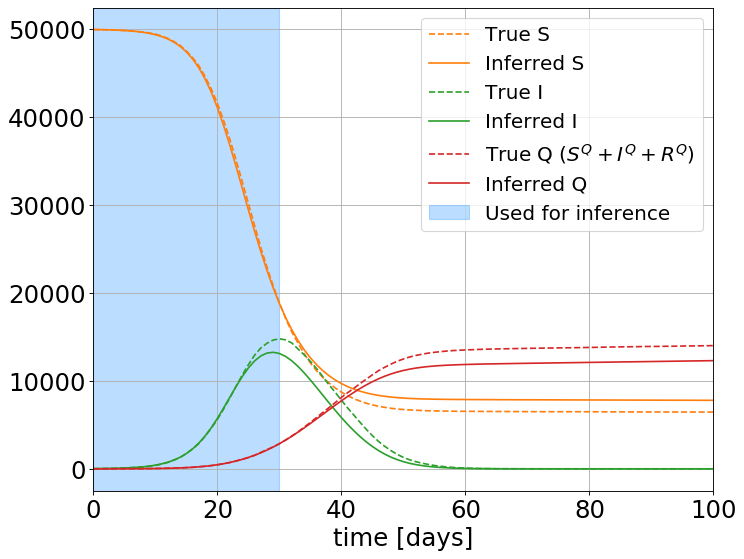

In [24]:
# plot the guessed trajectory and the true trajectory 
estimator.set_params(best_estimates)
det_model_inferred = pyross.deterministic.SppQ(model_spec,best_estimates, M, Ni)
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model_inferred, contactMatrix)

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(S, label='True S', ls='--', c='C1')
plt.plot(np.sum(x_det[:, 0*M:1*M],axis=1)*N, label='Inferred S', c='C1')
plt.plot(I, label='True I', ls='--', c='C2')
plt.plot(np.sum(x_det[:, 1*M:2*M],axis=1)*N, label='Inferred I', c='C2')
plt.plot(NQ, label='True Q ($S^Q+I^Q+R^Q$)', ls='--', c='C3')
plt.plot(np.sum(x_det[:, 4*M:5*M],axis=1)*N, label='Inferred Q', c='C3')


plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend(fontsize=18); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("time [days]")
plt.show()